In [1]:
import math
import random
import torch
import torchvision
import time 
from torchvision import datasets ,transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Dataset
from torch import nn 
from torch.nn.functional import relu ,softmax 
import copy 
from torch.utils.data import Subset
import pandas as pd 
import numpy as np
from PIL import Image
 


In [2]:
data_transform=transforms.Compose ([transforms.ToTensor()])


In [3]:


class light_source_dataset(Dataset):
    def __init__(self,path,transform):
        self.df_data=pd.read_csv(path)
        self.df_data['Classifier'] = pd.Categorical(pd.factorize(self.df_data['Classifier'])[0])
        self.labels=np.asarray(self.df_data.iloc[:,self.df_data.shape[1]-1])
        self.image_as_np=np.asarray(self.df_data.iloc[:,0:self.df_data.shape[1]-1]).astype('uint8')
        self.trans=transform
        
    def __len__(self):
        return len(self.df_data.index)
    def __getitem__(self,index):
        image_np=self.image_as_np[index,:,None]
       
        pillow_image=Image.fromarray(image_np.astype('uint8'))
        
        single_label=self.labels[index]
        if (self.trans is not None):
            img_as_tensor=self.trans(pillow_image)
        
        
            
        return (img_as_tensor,single_label)
        
dataset=light_source_dataset('Zoo/Zoo.csv',data_transform)
print(len(dataset))
train_size=int (len(dataset)*0.6)
test_size=len(dataset)-train_size
trainloader=DataLoader(dataset,batch_size=1)
torch.manual_seed(1)
train_data,test_data=torch.utils.data.random_split(dataset,[int (train_size), int (test_size)])
dataloader={'train':DataLoader(train_data,shuffle=False ,batch_size=16),
            'val':DataLoader(test_data,shuffle=False,batch_size=16
                            )}

dataset_sizes={'train':len(train_data),
               'val':len(test_data)}

device=torch.device("cuda:0"if torch.cuda.is_available () else "cpu")
print(dataset_sizes["train"])
print (dataset_sizes["val"])
#for images,labels in dataloader['train']:
 #   print(labels)

 
    



101
60
41


In [4]:

class Model(torch.nn.Module):
    def __init__(self):
        super (Model,self ).__init__()
        self .linear1=nn.Linear (16,100)
        self.linear2=nn.Linear (100,7)
        
    def Forward (self,x,mask,p):
        #feed forward function 
        x=x.view(-1,16)
        act1=relu(self.linear1(x))
        act1_masked =self.masking (act1,mask,p)
        act2=softmax(self.linear2(act1_masked ))
        return act2
    
    
    
    def masking (self,act1,mask,p):
        if (self.training ==True ):
            return ((act1*mask)/p)
        else :
            return (act1)
        



  
  
  


      

In [5]:
def train_model(model, criterion, optimizer,mask,p, num_epochs=25):
  # the mask has to be specified 

      
      since = time.time()

      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0
      losses=[]
      accuracies=[]

      for epoch in range(num_epochs):
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)

          # Each epoch has a training and validation phase
          for phase in ['train', 'val']:
              if phase == 'train':
                  
                  model.train()  # Set model to training mode
              else:

                  model.eval()   # Set model to evaluate mode

              running_loss = 0.0
              running_corrects = 0

              # Iterate over data.
              for inputs, labels in dataloader[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs= model.Forward(inputs,mask,p)

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)# backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #print (model.linear1.weight.grad)
                        #print (model.linear2.weight.grad)

                  # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                  

              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects.double() / dataset_sizes[phase]
            

              print('{} Loss: {:.4f} Acc: {:.4f} '.format(
                  phase, epoch_loss, epoch_acc))

              # deep copy the model
              if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
              if phase=='train':
                losses.append(epoch_loss)
                accuracies.append(epoch_acc)


          

      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
          time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f}'.format(best_acc))

      # load best model weights
      model.load_state_dict(best_model_wts)
      return model,losses,accuracies

In [6]:

class Population:
    
    def __init__(self,m,num,maskLength):
        # constructor for initialising the population list
        #list of DNA objects
        self.population=[]
        #muation rate for mutation
        self.mutation_rate=m
        #maximum number of entities in the population
        self.popmax=num

        self.maskLength=maskLength
        for i in range (num):
            #creating a dna object
            #an initial random population created 
            dna =DNA(self.maskLength)
            self.population.append (dna)
      
        self.matingPool=[]
    




    def calcFitness (self,model):
        # going through all the entities of population 
        #finding fitness of all population entities 
        for i in range(0,self.popmax):
            self.population[i].fitness (model)




    def naturalSelection(self):
        self.matingPool=[]
        maxFitness=0
        for i in range (self.popmax):
            # moving throught the entire population 
            if (self.population[i].fit>maxFitness):
                maxFitness=self.population[i].fit
       
        # max Fitness has the maximum loss score of the entire population  
        for i in range (self.popmax ):
        # iterating through the all inviduals of the population
            n=self.Mymap(self.population[i].fit,0,maxFitness,0,1)
        
            n=math.floor(n*100)
            
            for j in range (n):
                #creating mating pool
                self.matingPool.append (self.population[i])




    def Mymap(self,num,prevlow,prevhigh,nextlow,nexthigh):
        
        prevrange =float((num-prevlow)/(prevhigh-prevlow))
        return nextlow+(nexthigh-nextlow)*prevrange



    def   generate (self):
        for i in range (self.popmax ):
            index_1=math.floor(random.randint  (0,len(self.matingPool)-1))
            index_2=math.floor (random.randint (0,len(self.matingPool)-1))
            parent1=self.matingPool[index_1]
            parent2=self.matingPool[index_2]
            child=parent1.crossover(parent2)
            child.mutate(self.mutation_rate)
            self.population[i]=child 


    def fittest(self):
        #returns the fiitest individual mask of the population 
        #also returns the keeping probability of the fittest mask 
        fittest=self.population[0]
        for i  in range (self.popmax):
            if (fittest.fit<self.population[i].fit):
                fittest=self.population[i]
        return fittest,fittest.keep_prob()








In [7]:



class DNA:
    
    
    def __init__(self,maskLength):
        #constructor for the creation of the mask as a gene object 
        self.maskLength=maskLength
        #creation of mask 
        self.gene=torch.bernoulli(torch.empty(1,maskLength).uniform_(0,1))
        self.fit=0




    def keep_prob (self):

        num_one =0
        for i in range (self.maskLength):
            if (self.gene[0,i]==1):
                num_one=num_one+1
        return float(num_one/self.maskLength)




    def fitness(self,model):
        # finding the fitness of a particular mask
        #accuracy of all training set is the fitness in one epoch
        #putting model in train mode 
        running_loss=0
        running_corrects=0
        model.train()
        
        for inputs,labels in dataloader ['train']:
            inputs=inputs.to(device)
            labels=labels.to(device )
            outputs=model.Forward(inputs,self.gene,self.keep_prob())
            _,preds=torch.max(outputs,1)
            loss=criterion (outputs,labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        
        self.fit=epoch_acc
        return epoch_acc











    def crossover (self,parent2):
        #one parent is the passed in the argument 
        #another parent is the one from which this function is called 
        #another parent is self.gene
        child =DNA(self.maskLength)
        midpoint =random .randint (0,self.maskLength-1)
        for i in range (0,self.maskLength):
            if (i>midpoint):
                child.gene [0,i]=self.gene[0,i]
            else :
                child.gene [0,i]=parent2.gene[0,i]
        
        return child 

    def mutate(self,mutation_rate):
        #randomly activate some of the nodes  
        #mutate some of the genes 
        for i in range (self.maskLength):
            if (random.randint (0,99)<=mutation_rate*100):
                self.gene[0,i]=1








    

In [8]:
mutation_rate =0.20
max_population=30
maskLength=100
#seeded so that each time same initial weights generated 
torch.manual_seed(6)
model=Model()#creating the object of the class
model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)



In [9]:
#control block controls the epochs and the generations of mask
#step 1 an object of the population class randomly generating the first population 
#step2 :calculate fitness of each entitiy of the population 
#step3: creates a mating pool of the population based on the worst two performing parent 
#step 4 :fittest mask of the generating along with keep_prob found 
#step 5: if 0th ,10th ,20th, the epochs starts training on the worst performing mask /other wise new generation is created 

epochgens=0
population =Population(mutation_rate,max_population,maskLength)
total_acc=[]
while (epochgens<=200):
    print ('Epoch generations (',epochgens,'/200)',end=' :')
    population .calcFitness(model)
    population.naturalSelection()
    fittestmask,p=population .fittest()
    accuracy=fittestmask.fitness(model)
    print ("accuracy(fittest mask)",accuracy,"keep_prob",p,end='\n')
    if (epochgens%10==0):
        model,losses,accuracies=train_model(model,criterion,optimizer,fittestmask.gene,p,30)
        total_acc=total_acc+accuracies
    population.generate()
    epochgens+=1



Epoch generations ( 0 /200) :

D:\ana\envs\packt_torch\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


accuracy(fittest mask) tensor(0.2000, dtype=torch.float64) keep_prob 0.49
Epoch 0/29
----------
train Loss: 1.9458 Acc: 0.2000 
val Loss: 1.9476 Acc: 0.0732 
Epoch 1/29
----------
train Loss: 1.9457 Acc: 0.2000 
val Loss: 1.9476 Acc: 0.0732 
Epoch 2/29
----------
train Loss: 1.9455 Acc: 0.2000 
val Loss: 1.9475 Acc: 0.0732 
Epoch 3/29
----------
train Loss: 1.9453 Acc: 0.2000 
val Loss: 1.9474 Acc: 0.0732 
Epoch 4/29
----------
train Loss: 1.9450 Acc: 0.2000 
val Loss: 1.9473 Acc: 0.0732 
Epoch 5/29
----------
train Loss: 1.9447 Acc: 0.2000 
val Loss: 1.9471 Acc: 0.0976 
Epoch 6/29
----------
train Loss: 1.9444 Acc: 0.2000 
val Loss: 1.9470 Acc: 0.1951 
Epoch 7/29
----------
train Loss: 1.9440 Acc: 0.2000 
val Loss: 1.9469 Acc: 0.1951 
Epoch 8/29
----------
train Loss: 1.9437 Acc: 0.2000 
val Loss: 1.9467 Acc: 0.1951 
Epoch 9/29
----------
train Loss: 1.9434 Acc: 0.2000 
val Loss: 1.9466 Acc: 0.1951 
Epoch 10/29
----------
train Loss: 1.9430 Acc: 0.2000 
val Loss: 1.9465 Acc: 0.1951 
E

train Loss: 1.9387 Acc: 0.4500 
val Loss: 1.9414 Acc: 0.3415 
Epoch 14/29
----------
train Loss: 1.9384 Acc: 0.4500 
val Loss: 1.9412 Acc: 0.3415 
Epoch 15/29
----------
train Loss: 1.9382 Acc: 0.4500 
val Loss: 1.9410 Acc: 0.3415 
Epoch 16/29
----------
train Loss: 1.9379 Acc: 0.4500 
val Loss: 1.9409 Acc: 0.3415 
Epoch 17/29
----------
train Loss: 1.9377 Acc: 0.4500 
val Loss: 1.9407 Acc: 0.3415 
Epoch 18/29
----------
train Loss: 1.9374 Acc: 0.4500 
val Loss: 1.9406 Acc: 0.3415 
Epoch 19/29
----------
train Loss: 1.9371 Acc: 0.4500 
val Loss: 1.9404 Acc: 0.3415 
Epoch 20/29
----------
train Loss: 1.9369 Acc: 0.4500 
val Loss: 1.9402 Acc: 0.3415 
Epoch 21/29
----------
train Loss: 1.9366 Acc: 0.4500 
val Loss: 1.9401 Acc: 0.3415 
Epoch 22/29
----------
train Loss: 1.9363 Acc: 0.4500 
val Loss: 1.9399 Acc: 0.3415 
Epoch 23/29
----------
train Loss: 1.9361 Acc: 0.4500 
val Loss: 1.9397 Acc: 0.3415 
Epoch 24/29
----------
train Loss: 1.9358 Acc: 0.4500 
val Loss: 1.9396 Acc: 0.3415 
Epo

train Loss: 1.9340 Acc: 0.4500 
val Loss: 1.9384 Acc: 0.3415 
Training complete in 0m 0s
Best val Acc: 0.341463
Epoch generations ( 41 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 42 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 43 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 44 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 45 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 46 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 47 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 48 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 49 /200) :accuracy(fittest mask) tensor(0.45

Epoch generations ( 69 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 70 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch 0/29
----------
train Loss: 1.9407 Acc: 0.4500 
val Loss: 1.9426 Acc: 0.3415 
Epoch 1/29
----------
train Loss: 1.9404 Acc: 0.4500 
val Loss: 1.9424 Acc: 0.3415 
Epoch 2/29
----------
train Loss: 1.9402 Acc: 0.4500 
val Loss: 1.9423 Acc: 0.3415 
Epoch 3/29
----------
train Loss: 1.9399 Acc: 0.4500 
val Loss: 1.9421 Acc: 0.3415 
Epoch 4/29
----------
train Loss: 1.9397 Acc: 0.4500 
val Loss: 1.9420 Acc: 0.3415 
Epoch 5/29
----------
train Loss: 1.9394 Acc: 0.4500 
val Loss: 1.9418 Acc: 0.3415 
Epoch 6/29
----------
train Loss: 1.9392 Acc: 0.4500 
val Loss: 1.9416 Acc: 0.3415 
Epoch 7/29
----------
train Loss: 1.9389 Acc: 0.4500 
val Loss: 1.9415 Acc: 0.3415 
Epoch 8/29
----------
train Loss: 1.9387 Acc: 0.4500 
val Loss: 1.9413 Acc: 0.3415 
Epoch 9/29
----------
train Loss: 1.93

train Loss: 1.9374 Acc: 0.4500 
val Loss: 1.9405 Acc: 0.3415 
Epoch 12/29
----------
train Loss: 1.9371 Acc: 0.4500 
val Loss: 1.9404 Acc: 0.3415 
Epoch 13/29
----------
train Loss: 1.9368 Acc: 0.4500 
val Loss: 1.9402 Acc: 0.3415 
Epoch 14/29
----------
train Loss: 1.9366 Acc: 0.4500 
val Loss: 1.9400 Acc: 0.3415 
Epoch 15/29
----------
train Loss: 1.9363 Acc: 0.4500 
val Loss: 1.9399 Acc: 0.3415 
Epoch 16/29
----------
train Loss: 1.9361 Acc: 0.4500 
val Loss: 1.9397 Acc: 0.3415 
Epoch 17/29
----------
train Loss: 1.9358 Acc: 0.4500 
val Loss: 1.9395 Acc: 0.3415 
Epoch 18/29
----------
train Loss: 1.9355 Acc: 0.4500 
val Loss: 1.9394 Acc: 0.3415 
Epoch 19/29
----------
train Loss: 1.9353 Acc: 0.4500 
val Loss: 1.9392 Acc: 0.3415 
Epoch 20/29
----------
train Loss: 1.9350 Acc: 0.4500 
val Loss: 1.9390 Acc: 0.3415 
Epoch 21/29
----------
train Loss: 1.9347 Acc: 0.4500 
val Loss: 1.9389 Acc: 0.3415 
Epoch 22/29
----------
train Loss: 1.9345 Acc: 0.4500 
val Loss: 1.9387 Acc: 0.3415 
Epo

val Loss: 1.9376 Acc: 0.3415 
Epoch 27/29
----------
train Loss: 1.9325 Acc: 0.4500 
val Loss: 1.9375 Acc: 0.3415 
Epoch 28/29
----------
train Loss: 1.9322 Acc: 0.4500 
val Loss: 1.9373 Acc: 0.3415 
Epoch 29/29
----------
train Loss: 1.9319 Acc: 0.4500 
val Loss: 1.9371 Acc: 0.3415 
Training complete in 0m 1s
Best val Acc: 0.341463
Epoch generations ( 111 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 112 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 113 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 114 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 115 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 116 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 117 /200) :accuracy(f

Epoch generations ( 137 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 138 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 139 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 140 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch 0/29
----------
train Loss: 1.9389 Acc: 0.4500 
val Loss: 1.9414 Acc: 0.3415 
Epoch 1/29
----------
train Loss: 1.9386 Acc: 0.4500 
val Loss: 1.9413 Acc: 0.3415 
Epoch 2/29
----------
train Loss: 1.9383 Acc: 0.4500 
val Loss: 1.9411 Acc: 0.3415 
Epoch 3/29
----------
train Loss: 1.9381 Acc: 0.4500 
val Loss: 1.9410 Acc: 0.3415 
Epoch 4/29
----------
train Loss: 1.9378 Acc: 0.4500 
val Loss: 1.9408 Acc: 0.3415 
Epoch 5/29
----------
train Loss: 1.9376 Acc: 0.4500 
val Loss: 1.9406 Acc: 0.3415 
Epoch 6/29
----------
train Loss: 1.9373 Acc: 0.4500 
val Loss: 1.9405 Acc: 0.34

train Loss: 1.9349 Acc: 0.4500 
val Loss: 1.9390 Acc: 0.3415 
Epoch 14/29
----------
train Loss: 1.9346 Acc: 0.4500 
val Loss: 1.9388 Acc: 0.3415 
Epoch 15/29
----------
train Loss: 1.9343 Acc: 0.4500 
val Loss: 1.9386 Acc: 0.3415 
Epoch 16/29
----------
train Loss: 1.9341 Acc: 0.4500 
val Loss: 1.9384 Acc: 0.3415 
Epoch 17/29
----------
train Loss: 1.9338 Acc: 0.4500 
val Loss: 1.9383 Acc: 0.3415 
Epoch 18/29
----------
train Loss: 1.9335 Acc: 0.4500 
val Loss: 1.9381 Acc: 0.3415 
Epoch 19/29
----------
train Loss: 1.9332 Acc: 0.4500 
val Loss: 1.9379 Acc: 0.3415 
Epoch 20/29
----------
train Loss: 1.9330 Acc: 0.4500 
val Loss: 1.9378 Acc: 0.3415 
Epoch 21/29
----------
train Loss: 1.9327 Acc: 0.4500 
val Loss: 1.9376 Acc: 0.3415 
Epoch 22/29
----------
train Loss: 1.9324 Acc: 0.4500 
val Loss: 1.9374 Acc: 0.3415 
Epoch 23/29
----------
train Loss: 1.9321 Acc: 0.4500 
val Loss: 1.9372 Acc: 0.3415 
Epoch 24/29
----------
train Loss: 1.9318 Acc: 0.4500 
val Loss: 1.9370 Acc: 0.3415 
Epo

val Loss: 1.9359 Acc: 0.3415 
Epoch 29/29
----------
train Loss: 1.9298 Acc: 0.4500 
val Loss: 1.9357 Acc: 0.3415 
Training complete in 0m 1s
Best val Acc: 0.341463
Epoch generations ( 181 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 182 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 183 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 184 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 185 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 186 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 187 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 188 /200) :accuracy(fittest mask) tensor(0.4500, dtype=torch.float64) keep_prob 1.0
Epo

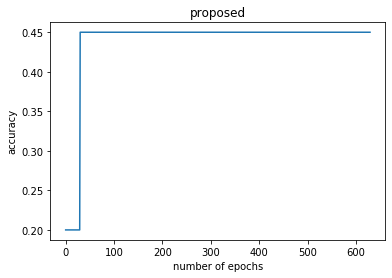

In [10]:
import matplotlib.pyplot as plt 
plt.plot(range(630),total_acc)
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.title('proposed')
plt.savefig('48_1440...1000/ga_drop1.jpg')